This notebook investigates the zero bottom velocities that have been observed in certain areas of the GLORYSV4 model. These zero bottom velocities cover a large area and are believed to be unphysical. The problem was first observed after downloading csv files from the Ocean Navigator.

Strategy:
1. Confirm the validity of the ON algorithm for identityfing the bottom velocity
2. Check if the zero velocities exist in the netCDF files (rule outON as a source of the issue)
3. Check if this pattern is seen in the new GLORYS 1/12 degree model

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib inline

/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


# 1. Confirm Validity

In [2]:
def bottom_data(var):
    """Ocean navigator's algorithm for identyifing the bottom velocity by looking at where masking starts"""
    reshaped = np.ma.masked_invalid(var.reshape(var.shape[0],-1))
    edges = np.array(np.ma.notmasked_edges(reshaped,axis=0))
    depths = edges[1,0,:]
    indices=edges[1,1,:]
    print(depths)
    data = np.ma.MaskedArray(np.zeros(var.shape[1:]),mask=True,dtype=var.dtype)
    data[np.unravel_index(indices,data.shape)]=reshaped[depths,indices]
    return data

In [3]:
def bottom_data_mbathy(var, mbathy):
    """An alternative algorithm for idenitifying the bottom velocity by sourcing the index
    of the bottom grid cell (mbathy) provided by the mesh file."""
    data = np.ma.MaskedArray(np.zeros(var.shape[1:]),mask=True,dtype=var.dtype)
    for i in range(mbathy.shape[-1]):
        for j in range(mbathy.shape[0]):
            data[j,i] = var[mbathy[j,i]-1,j,i]
    return data

In [4]:
dU = xr.open_dataset('/home/soontiensn/remote2/hank/glorys/v4/MONTHLY_2015/GLORYS2V4_ORCA025_201512_gridU.nc')
u = dU.vozocrtx.values[0,...]
lon=dU.nav_lon.values
lat=dU.nav_lat.values

In [5]:
mesh = xr.open_dataset('/home/soontiensn/remote2/hank/grids/glorys/GLORYS2V4_mesh_mask.nc')
mbathy=mesh.mbathy.values[0,:,:]
mbathy.shape

(1021, 1442)

In [6]:
u_bottom = bottom_data(u)

[37 38 37 ...  8  8  8]


In [7]:
u_bottom_mbathy = bottom_data_mbathy(u, mbathy)

In [8]:
(u_bottom==u_bottom_mbathy).all()

True

Indeed the bottom velocity using the Ocena Navigator algorithm is correct.

# 2. Issues persists in NetCDF files?

I will answer this question by plotting

/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.


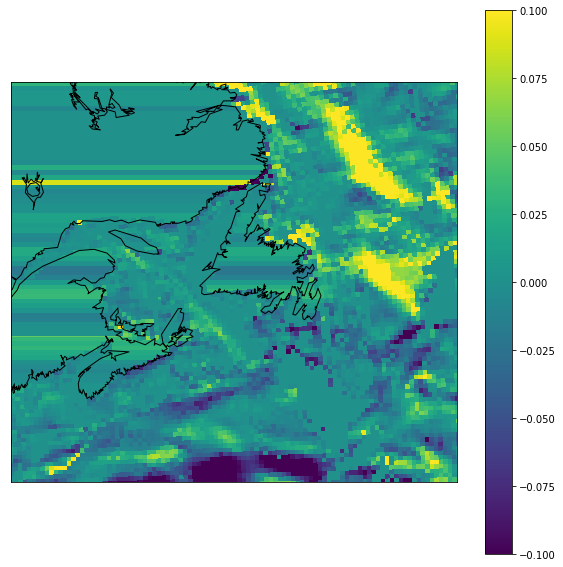

In [9]:
m = Basemap(projection='merc',llcrnrlat=40,urcrnrlat=55,llcrnrlon=-70,urcrnrlon=-45,resolution='l')
x,y=m(lon,lat)
fig, ax = plt.subplots(1,1,figsize=(10,10))
mesh = m.pcolormesh(x,y,u_bottom_mbathy,vmin=-.1,vmax=.1,ax=ax)
m.drawcoastlines()
plt.colorbar(mesh,ax=ax)

Are the velocties exactly zero or just close?

/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.


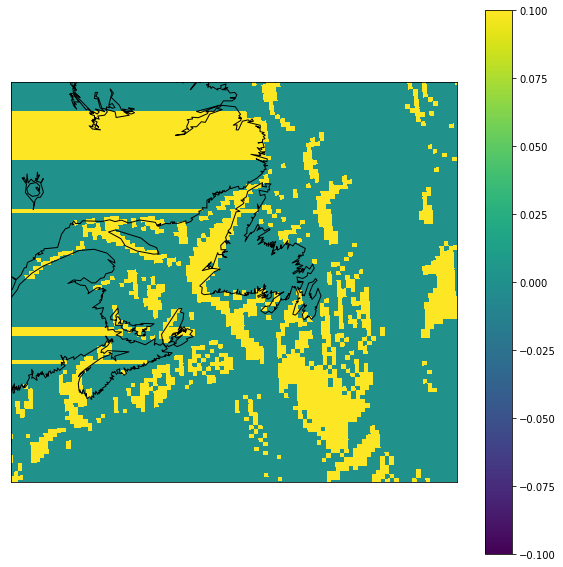

In [10]:
m = Basemap(projection='merc',llcrnrlat=40,urcrnrlat=55,llcrnrlon=-70,urcrnrlon=-45,resolution='l')
x,y=m(lon,lat)
fig, ax = plt.subplots(1,1,figsize=(10,10))
mask = u_bottom ==0
mesh = m.pcolormesh(x,y,mask,vmin=-.1,vmax=.1,ax=ax)
m.drawcoastlines()
plt.colorbar(mesh,ax=ax)

So indeed, the zero velocities exist in the netCDF files. They aren't just close to zero but are exactly zero. This seems unphysical!


# 3. GLORYS 1/12
Gloyrs 1/12 degree

In [11]:
dU = xr.open_dataset('/home/soontiensn/remote2/hank/cmems/GLOBAL_REANALYSIS_PHY_001_030/global-reanalysis-phy-001-030-monthly/2018/mercatorglorys12v1_gl12_mean_201812.nc')
u = dU.uo.values[0,...]
lon=dU.longitude.values
lat=dU.latitude.values
lons,lats=np.meshgrid(lon,lat)

In [12]:
u_bottom = bottom_data(u)

[32 32 32 ... 45 45 45]


/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.


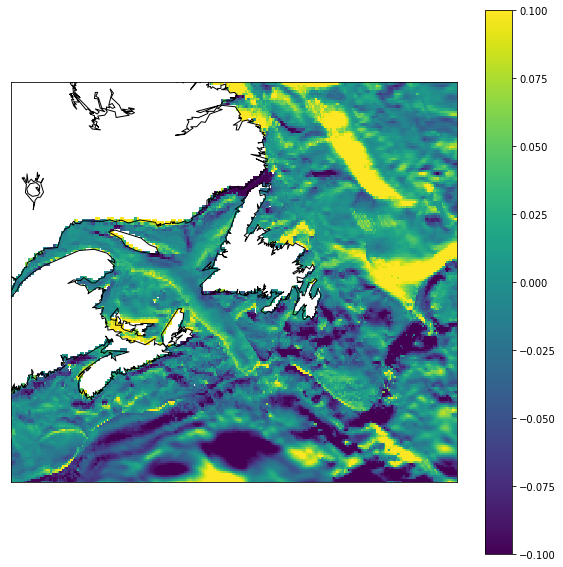

In [13]:
m = Basemap(projection='merc',llcrnrlat=40,urcrnrlat=55,llcrnrlon=-70,urcrnrlon=-45,resolution='l')
x,y=m(lons,lats)
fig, ax = plt.subplots(1,1,figsize=(10,10))
mesh = m.pcolormesh(x,y,u_bottom,vmin=-.1,vmax=.1,ax=ax)
m.drawcoastlines()
plt.colorbar(mesh,ax=ax)

# Conclusion
1. ON algorithm for bottom velocity is correct.
2. Zero bottom velocity exists in the GLORYS V4 netCDF file so the issue is unrelated to the ON.
3. The zero bottom velocity does not exist in the GLORYS 1/12 degree model. 
4. The zero bottom velocity is unphysical.